In [1]:
# Import packages 
import sys
sys.path.append(r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning')

import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd
from utils.satellite_data_functions import *

import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import num2date
import pandas as pd
import rioxarray
import netCDF4

import numpy as np

In [2]:
# Set input directory, change working directory, set API url
inDir, outDir, api_login, api = set_directories_and_api()

In [3]:
#Satellite name
sensor_name = 'MOD13A3.061'

### Login

In [4]:
# login
response = r.post(api_login, auth=('oxford_OII', 'hidden'))
token_response = response.json()
print(token_response)

{'token_type': 'Bearer', 'token': 'pb3tpzkO5JdeZ0tQKti7A1dKDIojD-IBNcJ-Hc4n3zjAcaj2Zw0GcriiKZRmn4drjGnwsnKCSn3uvrlsOmHLWg', 'expiration': '2023-11-21T14:46:03Z'}


### Check available layers

In [5]:
# # How many products does appeears support?
# product_response = r.get('{}product'.format(api)).json()                         # request all products in the product service
# print('AρρEEARS currently supports {} products.'.format(len(product_response)))  # Print no. products available in AppEEARS

In [6]:
# # Check the sensor product information 
# products = {p['ProductAndVersion']: p for p in product_response} # Create a dictionary indexed by product name & version
# products[sensor_name]                                            # Print information for a given product (i.e., MOD13A1.006)

In [7]:
# What are the variables in this product?
prods = [sensor_name]
lst_response = r.get('{}product/{}'.format(api, prods[0])).json()  # Request layers for this product
list(lst_response.keys())

['_1_km_monthly_EVI',
 '_1_km_monthly_MIR_reflectance',
 '_1_km_monthly_NDVI',
 '_1_km_monthly_NIR_reflectance',
 '_1_km_monthly_VI_Quality',
 '_1_km_monthly_blue_reflectance',
 '_1_km_monthly_pixel_reliability',
 '_1_km_monthly_red_reflectance',
 '_1_km_monthly_relative_azimuth_angle',
 '_1_km_monthly_sun_zenith_angle',
 '_1_km_monthly_view_zenith_angle']

### Specify layers

In [8]:
# Layers of interest
layers = [(sensor_name, '_1_km_monthly_NDVI')]

In [9]:
# Take tupled list (layers) and create a list of dictionaries to store each layer+product combination. 
# This will make it easier to insert into the json file used to submit a request
prodLayer = []
for l in layers:
    prodLayer.append({
            "layer": l[1],
            "product": l[0]
          })
prodLayer

[{'layer': '_1_km_monthly_NDVI', 'product': 'MOD13A3.061'}]

### Prepare token

In [10]:
token = token_response['token']                      # Save login token to a variable
head = {'Authorization': 'Bearer {}'.format(token)}  # Create a header to store token information, needed to submit a request

### Import shapefile and convert to json

In [11]:
# import shapefile
shapefile = gpd.read_file('4_data/RAW_DATA/SHAPEFILE/gadm36_IND_0.shp') # Read in shapefile as dataframe using geopandas
# print(nps.head())       

In [12]:
# Get the shapefile into the right format for the appeears API
shapefile_clean = shapefile[shapefile['GID_0']=='IND'].to_json() # Extract India row
shapefile_clean = json.loads(shapefile_clean)     

In [13]:
# Check available projections
projections = r.get('{}spatial/proj'.format(api)).json()  # Call to spatial API, return projs as json
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p  # Fill dictionary with `Name` as keys

### Compile a JSON object

In [14]:
task_name = 'INDIA_NDVI_1KM' # User-defined name of the task

In [15]:
task_type = ['point','area']        # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
startDate = '04-01-2000'            # Start of the date range for which to extract data: MM-DD-YYYY
endDate = '12-31-2022'              # End of the date range for which to extract data: MM-DD-YYYY
recurring = False                   # Specify True for a recurring date range
#yearRange = [2000,2016]            # if recurring = True, set yearRange, change start/end date to MM-DD

In [16]:
task = {
    'task_type': task_type[1],
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': startDate,
             'endDate': endDate
         }],
         'layers': prodLayer,
         'output': {
                 'format': {
                         'type': outFormat[1]}, 
                         'projection': proj},
         'geo': shapefile_clean,
    }
}

### Submit task request

In [17]:
task_response = r.post('{}task'.format(api), json=task, headers=head).json()  # Post json to the API task service, return response as json
task_response                                                                 # Print task response

{'task_id': '809945f6-3cc8-4007-826b-83b015cd3d69', 'status': 'pending'}

### Retrieve tasks status

In [21]:
params = {'limit': 2, 'pretty': True} # Limit API response to 2 most recent entries, return as pretty json

In [22]:
tasks_response = r.get('{}task'.format(api), params=params, headers=head).json() # Query task service, setting params and header 

In [25]:
# Next, take the task id returned from the task_response that was generated when submitting your request, and use the AρρEEARS API status service to check the status of your request.
task_id = '809945f6-3cc8-4007-826b-83b015cd3d69'
# task_id = task_response['task_id']                                               # Set task id from request submission
status_response = r.get('{}status/{}'.format(api, task_id), headers=head).json() # Call status service with specific task ID & user credentials

In [26]:
# Ping API until request is complete, then continue to Section 4
starttime = time.time()
while r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'] != 'done':
    print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get('{}task/{}'.format(api, task_id), headers=head).json()['status'])

done


### Download data request

In [27]:
# Set up output directory using input directory and task name
dest_dir = os.path.join(inDir, '4_data\RAW_DATA', task_name)

# Create the output directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Call API and return bundle contents for the task_id as json
bundle = r.get('{}bundle/{}'.format(api, task_id), headers=head).json()

# Create empty dictionary to store file information
files = {}

# Fill dictionary with file_id as keys and file_name as values
for f in bundle['files']:
    files[f['file_id']] = f['file_name']

# Download files and write them to the destination directory
for f in files:
    # Get a stream to the bundle file
    dl = r.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects='True')

    # Determine the output file name and path
    if files[f].endswith('.tif'):
        filename = files[f].split('/')[1]
    else:
        filename = files[f]
    filepath = os.path.join(dest_dir, filename)

    # Write file to destination directory
    with open(filepath, 'wb') as f:
        for data in dl.iter_content(chunk_size=8192):
            f.write(data)

# Print message indicating where downloaded files can be found
print('Downloaded files can be found at: {}'.format(dest_dir))

Downloaded files can be found at: C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\INDIA_NDVI_1KM


### Check the file

In [28]:
# Define the file path
file_path = r'C:\Users\djava\OneDrive\Documents\Oxford\Projects\india_rice_early_warning\4_data\RAW_DATA\INDIA_NDVI_1KM\MOD13A3.061_1km_aid0001.nc'

# Open the file with xarray
ds = xr.open_dataset(file_path)

# # Print the available variables
# print(ds.variables)
# Convert Julian date to correct format
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

C:\Users\djava\AppData\Local\Temp\ipykernel_7172\2692355292.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


In [29]:
ds

<xarray.Dataset>
Dimensions:                   (time: 273, lat: 3451, lon: 3508)
Coordinates:
  * time                      (time) datetime64[ns] 2000-04-01 ... 2022-12-01
  * lat                       (lat) float64 35.5 35.5 35.49 ... 6.762 6.754
  * lon                       (lon) float64 68.19 68.2 68.2 ... 97.4 97.4 97.41
Data variables:
    crs                       int8 ...
    _1_km_monthly_NDVI        (time, lat, lon) float32 ...
    _1_km_monthly_VI_Quality  (time, lat, lon) float64 ...
Attributes:
    title:        MOD13A3.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.39
    references:   See README.md
    history:      See README.md

In [30]:
# # Get the list of available dates
# date_list = [str(dt)[:10] for dt in ds['time'].values]
# date_list

In [31]:
def plot_ndvi_data(file_path, date=None):
    """
    Plots the NDVI data for a specific date in the xarray file.

    Args:
        file_path (str): Path to the xarray file containing the NDVI data.
        date (str): Date in the format 'YYYY-MM-DD' for the specific date to be plotted. Default is None, which
            will plot the first date available in the xarray file.

    Returns:
        None
    """
    # Open the file with xarray
    ds = xr.open_dataset(file_path)

    # Get the list of available dates
    date_list = [str(dt)[:10] for dt in ds['time'].values]

    # Select the NDVI variable and convert it to a DataArray
    ndvi = ds['_1_km_monthly_NDVI'].squeeze()

    # Plot the NDVI for the specified date or the first date available
    if date is None:
        ndvi.isel(time=0).plot.imshow(cmap='Greens', size=8)
        plt.title('NDVI for ' + date_list[0])
    else:
        date_idx = date_list.index(date)
        ndvi.isel(time=date_idx).plot.imshow(cmap='Greens', size=8)
        plt.title('NDVI for ' + date)

    # Show the plot
    plt.show()

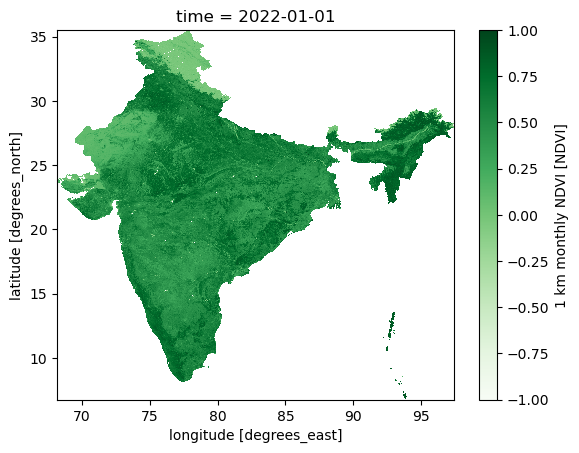

In [32]:
ds["_1_km_monthly_NDVI"].squeeze().sel(time="2022-01-01", method="nearest").plot(cmap="Greens")

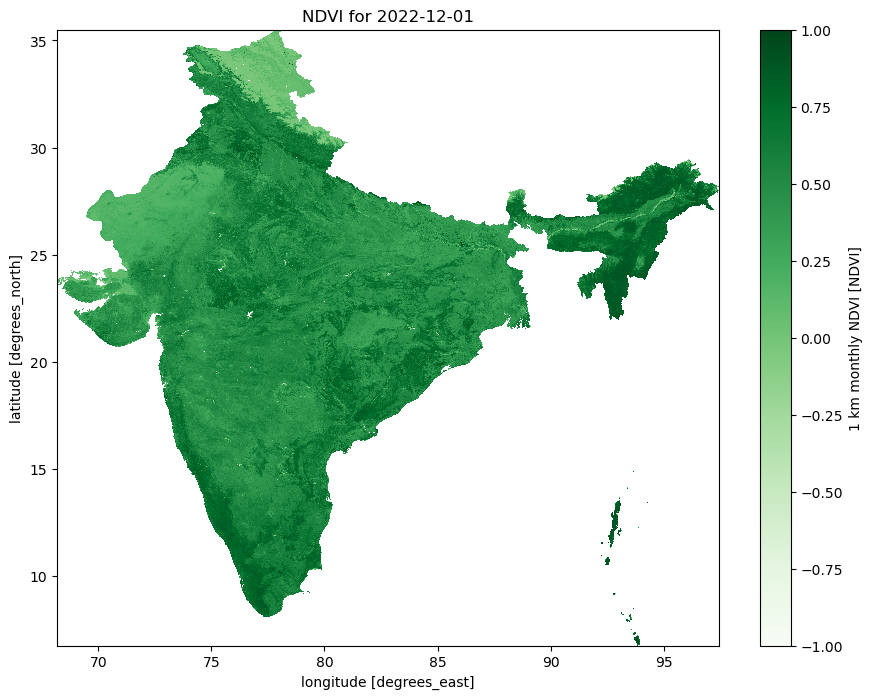

In [33]:
plot_ndvi_data(file_path, date='2022-12-01')